In [2]:
#################### MODEL FOR CLASS FULL DATASET ####################
# Please scroll down to "### MY DATA ONLY ###" for "2 Input Dataset", "3 Model Building and Testing"
# I put it after my full dataset model for convenience and organization. 

### START ###
#IMPORT LIBRARIES 
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.utils.data as data
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
import time

from torchsummary import summary

from sklearn.model_selection import train_test_split

from torch.utils.data.sampler import SubsetRandomSampler

#SET PARAMETERS 
bs = 4
lr = 0.01
epochs = 50
seed = 0
N=10
split = 0.2

#REPRODUCABILITY 
torch.manual_seed(seed)

In [3]:
#Compute mean and standard deviation of a dataset 
def dataset_mean_std(loader):
    mean = 0.0
    std = 0.0
    var = 0.0
    for image, label in loader:
        #image (10,3,56,56)
        #label (10)

        image = image.view(image.size(0), image.size(1), -1) 
        mean = mean + image.mean(2).sum(0)
        var = var + image.var(2).sum(0)

    mean = mean / len(loader.dataset)
    var = var / len(loader.dataset)
    std = torch.sqrt(var)
    
    return mean, std

In [4]:
#LOADS AND SPLITS TRAIN, VALID DATA 
def load_data(batch_size, split): 

    full = datasets.ImageFolder(root='training_v2/',transform = transforms.ToTensor()) 
    print(full)
    full_loader = data.DataLoader(full,batch_size = len(full), shuffle=True)    
    
    #Calculate mean of full dataset 
    mean, std = dataset_mean_std(full_loader) 
    print(mean,std)

    #Normalize the full dataset
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])
    
    #Define train & test datasets (just copies of the normalized full, to be split in the next lines)
    train = torchvision.datasets.ImageFolder(root='training_v2/', transform = trans)
    test = torchvision.datasets.ImageFolder(root='training_v2/', transform = trans) 

    #Split normalized train & test 
    idxs = list(range(len(train))) #create indices from 0 to the number of training data
    split = int(np.floor(split * len(train))) #rounded up to closest integers
    
    np.random.shuffle(idxs) #shuffle the numbers of the indices (so train and test are split randomly)

    train_idx, test_idx = idxs[split:], idxs[:split]

    train_samp = SubsetRandomSampler(train_idx) #randomly assigning samples to train/test
    test_samp = SubsetRandomSampler(test_idx)

    trainloader = data.DataLoader(train, sampler = train_samp, batch_size=batch_size)
    testloader = data.DataLoader(test, sampler = test_samp, batch_size=batch_size)

    return trainloader, testloader #randomly split data 

#train_loader,val_loader = load_data(bs,0.2)
#print(train_loader)

In [5]:
#DEFINE CNN CLASS 
class CNN(nn.Module): ####################################################################################
    def __init__(self): #shapes in comments are from the very first model's parameters (specified in assignment)
        super(CNN, self).__init__()
        
        #NUMBER OF KERNALS 10,30
        self.conv1 = nn.Conv2d(3, 30, 3) #(rgb channels, kernels, size of kernels 3x3) <-- stride = 1 by default
        self.pool = nn.MaxPool2d(2, 2) #(size 2x2, stride 2)
        
        self.conv2 = nn.Conv2d(30, 30, 3) #(input channels = output feature map from first layer) 
        self.conv3 = nn.Conv2d(30, 30, 3)
        self.conv4 = nn.Conv2d(30, 30, 3)
        
        #NUMBER OF NEURONS 8,32
        self.fc1 = nn.Linear(30,32) #(8x5x5 = 200 inputs for each neuron, 100 neurons) #INPUT= SIZE OF LAST POOL (-,1,2,3)
        self.fc2 = nn.Linear(32, 10) #(100 input neurons, 10 outputs/classes)

    def forward(self, x): #x is input 
        x = F.relu(self.conv1(x)) #(10,4,54,54)
        #print("1",x.shape)
        x = self.pool(x) #(10,4,27,27)
        #print("2",x.shape)

        x = F.relu(self.conv2(x)) #(10,8,23,23)
        #print("3",x.shape)
        x = self.pool(x) #(10,8,11,11)
        #print("4",x.shape)
   #####      
        x = F.relu(self.conv3(x)) #(10,8,23,23)
        #print("3",x.shape)
        x = self.pool(x) #(10,8,11,11)
        #print("4",x.shape)
        
        x = F.relu(self.conv4(x)) #(10,8,23,23)
        #print("3",x.shape)
        x = self.pool(x) #(10,8,11,11)
        #print("4",x.shape)
    #####
        x = x.view(-1, 30) #(10,968) #OUTPUT= SIZE OF LAST POOL (num0,num1*num2*num2) #########
        #print("5",x.shape)

        x = self.fc1(x) #(10,100) 
        #print("6",x.shape)
        x = self.fc2(x) #(10,10)
        #print("7",x.shape)

        return x

In [6]:
# INSTANTIATE MODEL, DEFINE LOSS FCN & OPTIMIZER 
def load_model(learning_rate):
    
    model = CNN() 
    loss_fnc = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate) 

    return model, loss_fnc, optimizer

In [7]:
# CALCULATES BATCHACC (in training)
def accuracy(predictions, labels):
    correct = 0 
    total = 0
    
    _, predicted = torch.max(predictions,1) #finds max, returns index of max (predicted label)
    
    total = total + len(labels) #can probably change to just len(labels) later
    correct = correct + (predicted.float() == labels).sum() 


    batchacc = correct.item() / total
    return batchacc
    

In [8]:
# CALCULATES VALIDATION ACC & LOSS (called at end of each epoch)
def evaluate(model, val_loader):
    correct = 0 
    total = 0 
    
    batchloss_accum = 0.0
    
    for i,data in enumerate(val_loader,0): #go through each batch in val_loader
        inputs, labels = data
        predictions = model(inputs.float()) 
        #predictions = model(inputs) 


        
        #Calculate accuracy 
        _, predicted = torch.max(predictions,1) #finds max, returns index of max (predicted label)


        total = total + len(labels) 
        
        correct = correct + (predicted.float() == labels.float()).sum() 
        acc = correct.item() / total
        
        #Calculate loss
        #labels_oh = F.one_hot(labels,10)
        loss = loss_fnc(predictions, labels.long()) #changed for cross entropy
        batchloss_accum = batchloss_accum + batchloss.item()
        
        
    avgbatchloss = batchloss_accum/len(train_loader)

    return acc, avgbatchloss
        


In [9]:
#PREPARE FOR THE LOOP 
torch.manual_seed(seed)

#Load data
train_loader,val_loader = load_data(bs,split) 
model,loss_fnc,optimizer = load_model(lr) #lr defined here 

#Store for plotting
loss_list = []
acc_list = []
nepoch = []

testacc_list = []
testloss_list = []

#TRAINING LOOP 
start_time = time.time()
for e in range(epochs): 
    nepoch = nepoch + [e]

    batchloss_accum = 0.0
    batchacc_accum = 0.0

    for i, data in enumerate(train_loader, 0): #len trainloader is number of batches 
        model.train() 
        correct = 0 
        total = 0 
        
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data #inputs = (10,3,56,56); labels = (10)


        inputs = Variable(inputs).float()
        labels = Variable(labels).float()
        #labels = torch.argmax(labels, dim=1)

        # Zero parameter gradients
        optimizer.zero_grad()

        #Run model on inputs
        outputs = model(inputs) #(10,10)

        #Compute loss
        batchloss = loss_fnc(outputs, labels.long()) #Changed for cross entropy (to labels.long())
        batchloss.backward()
        optimizer.step()

        batchloss_accum = batchloss_accum + batchloss.item() #added values of loss for all batches
        #print('batchloss',batchloss)

        batchacc = accuracy(outputs,labels)
        batchacc_accum = batchacc_accum + batchacc
        #print("Batch accuracy",batchacc)

        if i == len(train_loader)-1: #len(trainloader) is len(dataset) / images per batch
            model.eval()
            vacc, vloss = evaluate(model,val_loader)
            
            print("avg acc/epoch", batchacc_accum/len(train_loader))
            print('[%d, %5d] avg loss/epoch: %.3f' % (e + 1, i + 1, batchloss_accum/len(train_loader)))
            print("validation loss:", vloss)
            print("validation acc:", vacc)
            
            loss_list = loss_list + [batchloss_accum/len(train_loader)]
            acc_list = acc_list + [batchacc_accum/len(train_loader)]
            testacc_list.append(vacc)   
            testloss_list.append(vloss)

            batchloss_accum = 0.0
            batchacc_accum = 0.0 
                
endtime = time.time() - start_time
print('Finished Training')
print("Execution time", endtime)


Dataset ImageFolder
    Number of datapoints: 3815
    Root location: training_v2/
    StandardTransform
Transform: ToTensor()
tensor([0.6876, 0.6190, 0.5674]) tensor([0.1352, 0.1674, 0.1785])
avg acc/epoch 0.14515072083879424
[1,   763] avg loss/epoch: 2.267
validation loss: 0.5112189184166345
validation acc: 0.2437745740498034
avg acc/epoch 0.4737876802096986
[2,   763] avg loss/epoch: 1.566
validation loss: 0.24435314079099682
validation acc: 0.5884665792922673
avg acc/epoch 0.6942988204456094
[3,   763] avg loss/epoch: 0.968
validation loss: 0.06149014416559652
validation acc: 0.744429882044561
avg acc/epoch 0.7844036697247706
[4,   763] avg loss/epoch: 0.696
validation loss: 0.16831455458819788
validation acc: 0.7876802096985583
avg acc/epoch 0.8174967234600262
[5,   763] avg loss/epoch: 0.552
validation loss: 0.06603602359991712
validation acc: 0.8047182175622543
avg acc/epoch 0.848951507208388
[6,   763] avg loss/epoch: 0.450
validation loss: 0.5947994960869906
validation acc: 0

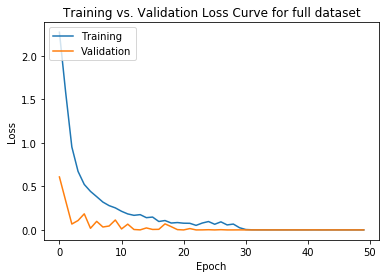

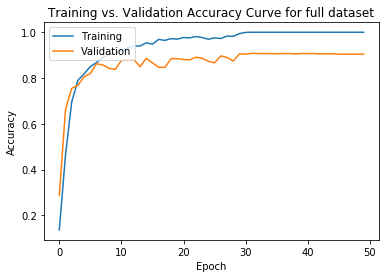

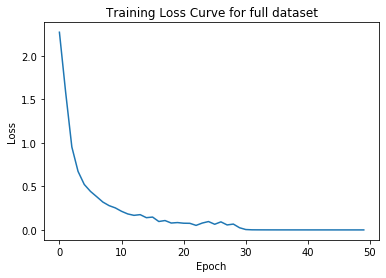

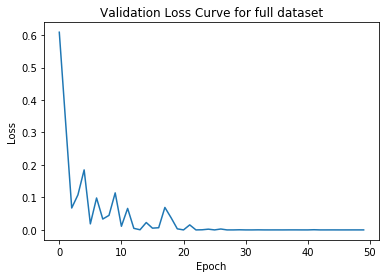

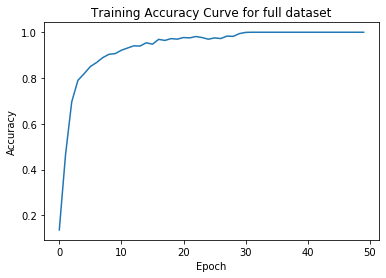

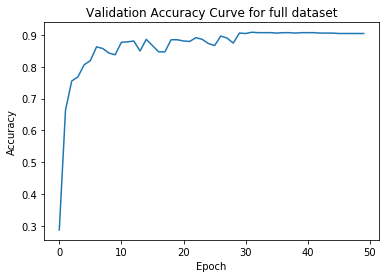

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 54, 54]             840
         MaxPool2d-2           [-1, 30, 27, 27]               0
            Conv2d-3           [-1, 30, 25, 25]           8,130
         MaxPool2d-4           [-1, 30, 12, 12]               0
            Conv2d-5           [-1, 30, 10, 10]           8,130
         MaxPool2d-6             [-1, 30, 5, 5]               0
            Conv2d-7             [-1, 30, 3, 3]           8,130
         MaxPool2d-8             [-1, 30, 1, 1]               0
            Linear-9                   [-1, 32]             992
           Linear-10                   [-1, 10]             330
Total params: 26,552
Trainable params: 26,552
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 1.04
Params size (MB): 0.10
Estimated Tot

In [17]:
#LOSS TOGETHER
plt.plot(nepoch,loss_list, label = 'Train')
plt.plot(nepoch,testloss_list, label = 'Valid')
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Training vs. Validation Loss Curve for full dataset")
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show() 

#ACCURACIES TOGETHER
plt.plot(nepoch,acc_list, label = 'Train')
plt.plot(nepoch,testacc_list, label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Training vs. Validation Accuracy Curve for full dataset")
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show() 

#TRAIN LOSS 
plt.plot(nepoch,loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Training Loss Curve for full dataset")
plt.show() 

#VALID LOSS
plt.plot(nepoch,testloss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.title("Validation Loss Curve for full dataset")
plt.show() 

#TRAIN ACC
plt.plot(nepoch,acc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Training Accuracy Curve for full dataset")
plt.show() 


#VALID ACC
plt.plot(nepoch,testacc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy") 
plt.title("Validation Accuracy Curve for full dataset")
plt.show() 


summary(model, input_size=(3, 56, 56))
### END ###